In [10]:
from tqdm import tqdm
from math import factorial
import scipy.stats as stats
import numpy as np
import itertools as itools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
from matplotlib import rc

%matplotlib inline
mpl.rcParams['figure.figsize'] = (20,10)

In [5]:
def evaluate_method(method, vis_method=plt.hist, subplot=None, target=[1, 2, 3, 4, 5, 6, 7, 8], title='', verbose=False):
    if verbose:
        print('running method {0}, title={1}'.format(method, title))
    rs = []
    perm_length = np.prod(list(range(1, len(target) + 1)))
    for idx, perm in enumerate(tqdm(itools.permutations(target), total=factorial(len(target)), desc="Computing Permutations")):
        rs.append(method(list(perm)))
    if subplot is None:
        plt.figure()
    else:
        plt.subplot(subplot)
    if vis_method == plt.hist:
        vis_method(rs, bins=len(set(rs)))
    else:
        vis_method(rs)
    plt.title(title)


def evaluate_methods(method_list, vis_method_list, subplot_list=None, target=[1, 2, 3, 4, 5, 6, 7, 8], title_list=None, verbose=False):
    assert len(method_list) == len(vis_method_list), 'method list and visualization method list must be the same length'
    assert subplot_list is None or len(subplot_list) == len(
        method_list), 'subplot list must be None or length of method list'
    assert title_list is None or len(title_list) == len(
        method_list), 'title list must be None or length of method list'
    if verbose:
        print('running all methods ({0})'.format(method_list))
    rss = [[] for _ in range(0, len(method_list))]
    perm_length = np.prod(list(range(1, len(target) + 1)))
    for idx, perm in enumerate(tqdm(itools.permutations(target), total=factorial(len(target)), desc="Computing Permutations")):
        for midx, method in enumerate(method_list):
            rss[midx].append(method(list(perm)))
    for idx, (vis_method, subplot, title) in enumerate(tqdm(zip(vis_method_list, subplot_list, title_list), desc="Plotting")):
        if subplot is None:
            plt.figure()
        else:
            plt.subplot(subplot)
        if vis_method == plt.hist:
            vis_method(rss[idx], bins=len(set(rss[idx])))
        else:
            vis_method(rss[idx])
        if title_list is not None and title is not None:
            plt.title(title)


def compare_methods(method0, method1, hist=False, subplot=None, target=[1, 2, 3, 4, 5, 6, 7, 8], title='', verbose=False):
    if verbose:
        print('comparing method {0} with method {1}, title={2}'.format(method0, method1, title))
    rs0 = []
    rs1 = []
    perm_length = np.prod(list(range(1, len(target) + 1)))
    for idx, perm in enumerate(tqdm(itools.permutations(target), total=factorial(len(target)), desc="Computing Permutations")):
        rs0.append(method0(list(perm)))
        rs1.append(method1(list(perm)))
    if subplot is None:
        plt.figure()
    else:
        plt.subplot(subplot)
    if verbose:
        print('counting and reducing...')
    cs = []
    rs_zipped = zip(rs0, rs1)
    unique = []
    unique_count = []
    for r0, r1 in zip(rs0, rs1):
        if not (r0, r1) in unique:
            unique.append((r0, r1))
            unique_count.append(rs_zipped.count((r0, r1)))
    rs0_unique, rs1_unique = np.transpose(unique)
    if verbose:
        print('plotting...')
    if hist:
        plt.hist2d(rs0, rs1)
    else:
        print('method0: {0}, method1: {1}, title:{2}, size:{3}'.format(method0, method1, title, len(rs0_unique)))
        plt.scatter(rs0_unique, rs1_unique, c=unique_count)
    plt.title(title)


#  From http://www.thesciencemill.com/Article/20141125-PythonSJT/permutation1.php
def cycle_decomposition(seq):
    #  a = [seq.index(i+1) for i in range(len(seq))]
    fund_set = [i+1 for i in range(len(seq))]
    cycle_list = []
    for start in fund_set:
        this_cycle = [start]
        for step in this_cycle:
            if seq[step-1] == start:
                cycle_list.append(this_cycle)
            else:
                this_cycle.append(seq[step-1])
                fund_set.remove(seq[step-1])
    return cycle_list


def continuous_decomposition(seq):
    decomposition = [[]]
    for i in seq:
        if len(decomposition[0]) == 0:
            decomposition[0].append(i)
        elif decomposition[-1][-1] == i - 1:
            decomposition[-1].append(i)
        else:
            decomposition.append([i])
    return decomposition


def list_flatten_2d(p):
    return [j for i in p for j in i]


#  From https://math.stackexchange.com/questions/1410088/how-to-determine-a-kind-of-distance-between-two-permutations
def transposition_distance(p):
    l = cycle_decomposition(p)
    return sum([len(x) for x in l]) - len(l)


def cycle_rearrangement_distance(p):
    l = continuous_decomposition(p)
    r = 0
    for i in range(1, len(l)):
        k = i
        swaps = 0
        while k > 0 and l[k][0] < l[k-1][0]:
            swaps += 1
            tmp = l[k]
            l[k] = l[k-1]
            l[k-1] = tmp
            k -= 1
        if swaps >= 1:
            r += 1
    return r

    
def kendall_tau(p, target=[1, 2, 3, 4, 5, 6, 7, 8]):
    r, _ = stats.kendalltau(target, p)
    return r


# ideas from https://math.stackexchange.com/questions/2492954/distance-between-two-permutations#2492977
def l1_matrix_distance(p):
    return np.sum(np.abs(np.array(p)-np.array(list(range(1, len(p)+1)))))


def l0_matrix_distance(p):
    return np.sum([a == b for a, b in zip(p, list(range(1, len(p)+1)))])


def kendall_tau_weighted(p, target=[1, 2, 3, 4, 5, 6, 7, 8], weights=None):
    if weights is None:
        r, _ = stats.weightedtau(target, p)
        return r
    
    if len(weights) < len(p):
        weights = weights + [1.0] * (len(p)-len(weights))

    def weighter(i):
        return weights[i]
    
    r, _ = stats.weightedtau(target, p, weigher=weighter)
    return r


def kendall_tau_weighted_1(p):  # This gives the traditional KT metric
    return kendall_tau_weighted(p, weights=[1]*len(p))


def kendall_tau_weighted_2(p):
    return kendall_tau_weighted(p, weights=[1, 2, 3, 4, 5, 6, 7, 8])


    
def kendall_tau_cycle_rearrangement_distance(p, target=[1, 2, 3, 4, 5, 6, 7, 8]):
    r, _ = stats.kendalltau(target, p)
    cr = cycle_rearrangement_distance(p)
    return r, cr


def get_random_perms(num_perms, perm_size=8):
    return [np.random.permutation(perm_size)+1 for _ in range(0, num_perms)]


def get_ktcr_probability_lut(perm_size):
    target = [i+1 for i in range(0, perm_size)]
    rs0 = []
    rs1 = []
    perm_length = np.prod(list(range(1, len(target) + 1)))
    for idx, perm in enumerate(itools.permutations(target)):
        r, cr = kendall_tau_cycle_rearrangement_distance(perm)
        rs0.append(r)
        rs1.append(cr)
    cs = []
    rs_zipped = zip(rs0, rs1)
    unique = []
    unique_count = []
    for r0, r1 in zip(rs0, rs1):
        if not (r0, r1) in unique:
            unique.append((r0, r1))
            unique_count.append(rs_zipped.count((r0, r1)))
    rs0_unique, rs1_unique = np.transpose(unique)

    probability_dictionary = {}
    for u, uc in zip(unique, unique_count):
        probability_dictionary[u] = float(uc)/float(perm_length)

    return probability_dictionary

Plotting: 100%|██████████████████████████████████████████████████████████████████████████| 8/8 [00:22<00:00,  2.80s/it]


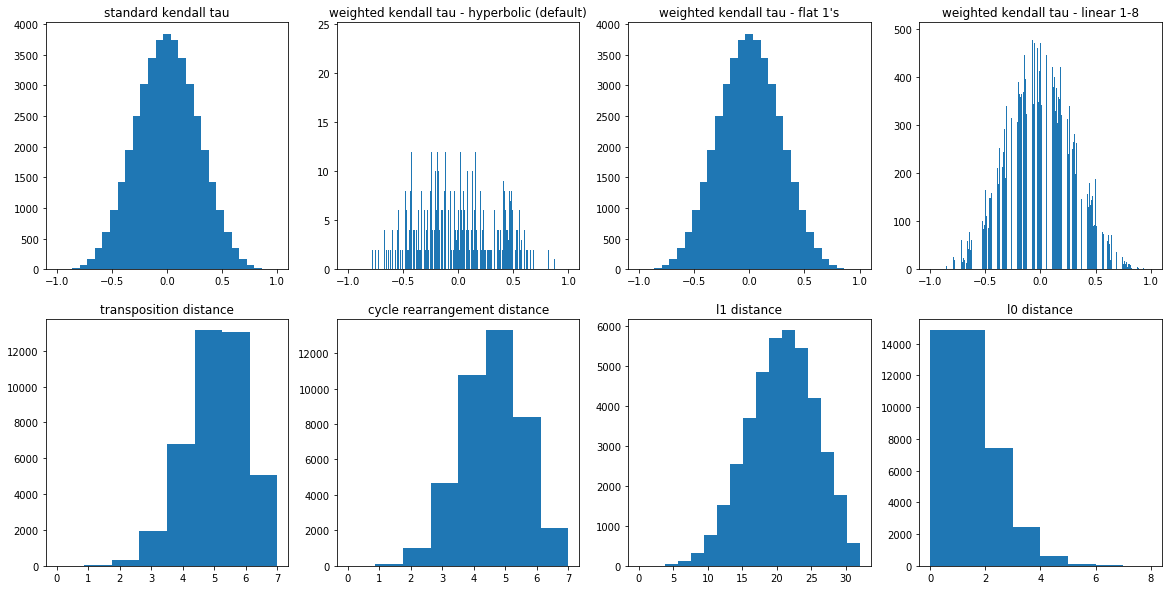

In [6]:
# Plot histogram of various methods across all permutations
visualization_method = plt.hist
method_list = [kendall_tau, kendall_tau_weighted, kendall_tau_weighted_1, kendall_tau_weighted_2, transposition_distance, cycle_rearrangement_distance,
               l1_matrix_distance, l0_matrix_distance]
subplot_list = [241, 242, 243, 244, 245, 246, 247, 248]
title_list = ['standard kendall tau', 'weighted kendall tau - hyperbolic (default)', 'weighted kendall tau - flat 1\'s',
              'weighted kendall tau - linear 1-8', 'transposition distance', 'cycle rearrangement distance',
              'l1 distance', 'l0 distance']
evaluate_methods(method_list, [visualization_method]*len(method_list), subplot_list=subplot_list, title_list=title_list)

plt.show()

In [ ]:
'''
# Running individually (slower)
evaluate_method(kendall_tau, vis_method=visualization_method, subplot=241, title='kendal tau')
evaluate_method(kendall_tau_weighted, vis_method=visualization_method, subplot=242, title='weighted kendal tau - hyperbolic')
evaluate_method(kendall_tau_weighted_1, vis_method=visualization_method, subplot=243, title='weighted kendal tau - flat 1\'s')
evaluate_method(kendall_tau_weighted_2, vis_method=visualization_method, subplot=244, title='weighted kendal tau - linear 1-8')
evaluate_method(transposition_distance, vis_method=visualization_method, subplot=245, title='transposition distance')
evaluate_method(cycle_rearrangement_distance, vis_method=visualization_method, subplot=246, title='cycle rearrangment distance')
evaluate_method(l1_matrix_distance, vis_method=visualization_method, subplot=247, title='l1 distance')
evaluate_method(l0_matrix_distance, vis_method=visualization_method, subplot=248, title='l0 distance')
'''

Computing Permutations: 100%|██████████████████████████████████████████████████| 40320/40320 [00:14<00:00, 2872.82it/s]


method0: <function kendall_tau at 0x0000000009E25438>, method1: <function cycle_rearrangement_distance at 0x0000000009CCBF98>, title:kendall tau vs. cycle rearrangement distance, size:138


Computing Permutations: 100%|██████████████████████████████████████████████████| 40320/40320 [00:13<00:00, 2880.82it/s]


method0: <function kendall_tau at 0x0000000009E25438>, method1: <function transposition_distance at 0x0000000009BF1DD8>, title:kendall tau vs. transposition distance, size:78


Computing Permutations: 100%|██████████████████████████████████████████████████| 40320/40320 [00:14<00:00, 2842.04it/s]


method0: <function kendall_tau at 0x0000000009E25438>, method1: <function l1_matrix_distance at 0x0000000009E25208>, title:kendall tau vs. l1 matrix distance, size:123


Computing Permutations: 100%|██████████████████████████████████████████████████| 40320/40320 [00:14<00:00, 2811.13it/s]


method0: <function kendall_tau at 0x0000000009E25438>, method1: <function l0_matrix_distance at 0x0000000009E250B8>, title:kendall tau vs. l0 matrix distance, size:127


Computing Permutations: 100%|█████████████████████████████████████████████████| 40320/40320 [00:00<00:00, 53831.77it/s]


method0: <function cycle_rearrangement_distance at 0x0000000009CCBF98>, method1: <function transposition_distance at 0x0000000009BF1DD8>, title:cycle rearrangement vs. transposition, size:44


Computing Permutations: 100%|█████████████████████████████████████████████████| 40320/40320 [00:01<00:00, 36990.83it/s]


method0: <function cycle_rearrangement_distance at 0x0000000009CCBF98>, method1: <function l1_matrix_distance at 0x0000000009E25208>, title:cycle rearrangement vs. l1, size:89


Computing Permutations: 100%|█████████████████████████████████████████████████| 40320/40320 [00:01<00:00, 35967.88it/s]


method0: <function cycle_rearrangement_distance at 0x0000000009CCBF98>, method1: <function l0_matrix_distance at 0x0000000009E250B8>, title:cycle rearrangement vs. l0, size:41


Computing Permutations: 100%|█████████████████████████████████████████████████| 40320/40320 [00:00<00:00, 46829.26it/s]


method0: <function transposition_distance at 0x0000000009BF1DD8>, method1: <function l1_matrix_distance at 0x0000000009E25208>, title:transposition vs. l1, size:78


Computing Permutations: 100%|█████████████████████████████████████████████████| 40320/40320 [00:00<00:00, 44259.06it/s]


method0: <function transposition_distance at 0x0000000009BF1DD8>, method1: <function l0_matrix_distance at 0x0000000009E250B8>, title:transposition tau vs. l0, size:17


Computing Permutations: 100%|█████████████████████████████████████████████████| 40320/40320 [00:01<00:00, 33239.90it/s]


method0: <function l1_matrix_distance at 0x0000000009E25208>, method1: <function l0_matrix_distance at 0x0000000009E250B8>, title:l1 vs. l0, size:73
showing plots...


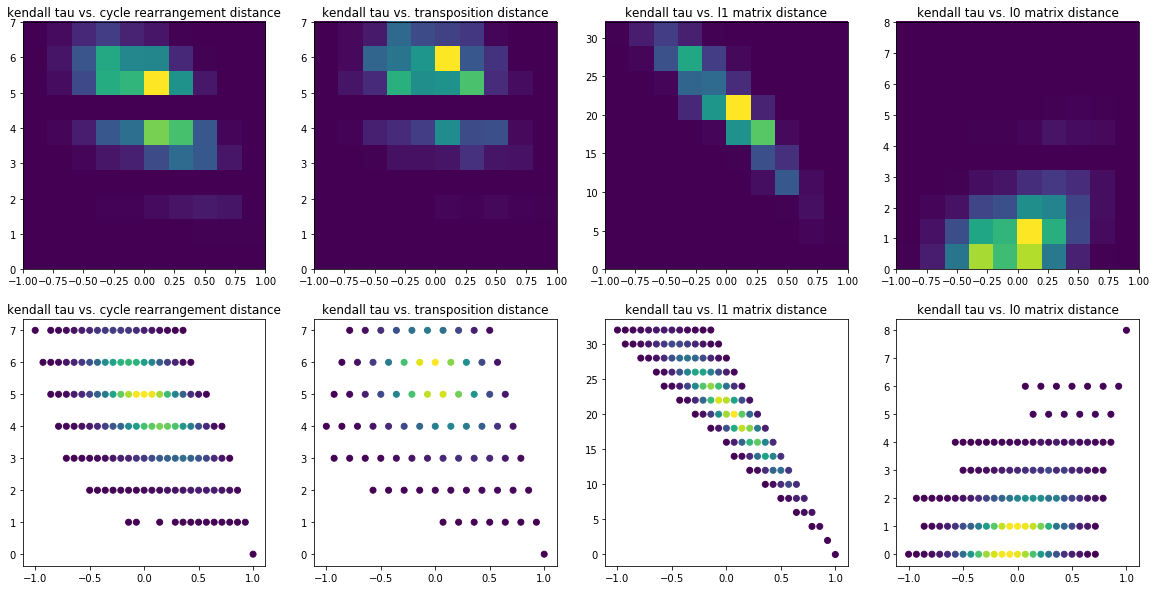

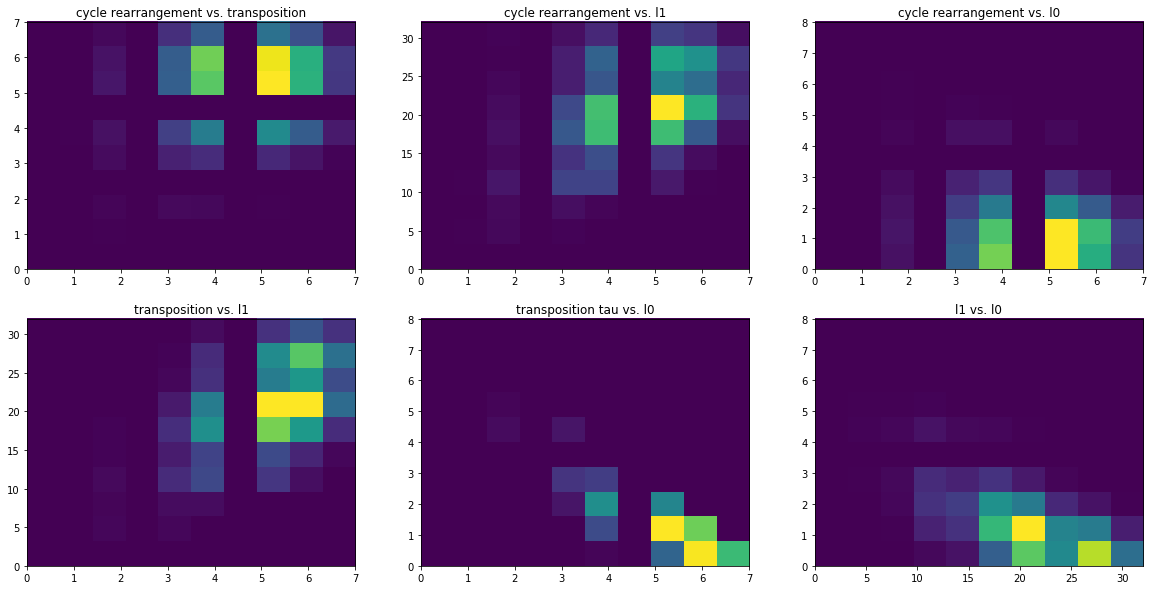

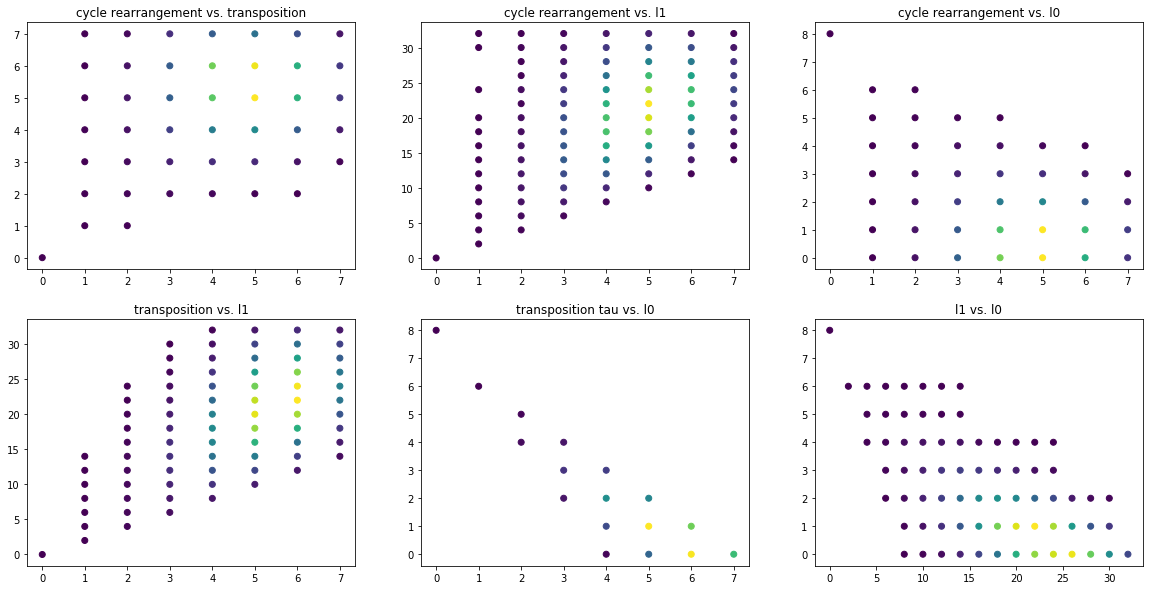

In [7]:
# Compare all methods
compare_methods(kendall_tau, cycle_rearrangement_distance, hist=True, subplot=241, title='kendall tau vs. cycle rearrangement distance')
compare_methods(kendall_tau, transposition_distance, hist=True, subplot=242, title='kendall tau vs. transposition distance')
compare_methods(kendall_tau, l1_matrix_distance, hist=True, subplot=243, title='kendall tau vs. l1 matrix distance')
compare_methods(kendall_tau, l0_matrix_distance, hist=True, subplot=244, title='kendall tau vs. l0 matrix distance')
compare_methods(kendall_tau, cycle_rearrangement_distance, hist=False, subplot=245, title='kendall tau vs. cycle rearrangement distance')
compare_methods(kendall_tau, transposition_distance, hist=False, subplot=246, title='kendall tau vs. transposition distance')
compare_methods(kendall_tau, l1_matrix_distance, hist=False, subplot=247, title='kendall tau vs. l1 matrix distance')
compare_methods(kendall_tau, l0_matrix_distance, hist=False, subplot=248, title='kendall tau vs. l0 matrix distance')

plt.figure()

compare_methods(cycle_rearrangement_distance, transposition_distance, hist=True, subplot=231, title='cycle rearrangement vs. transposition')
compare_methods(cycle_rearrangement_distance, l1_matrix_distance, hist=True, subplot=232, title='cycle rearrangement vs. l1')
compare_methods(cycle_rearrangement_distance, l0_matrix_distance, hist=True, subplot=233, title='cycle rearrangement vs. l0')
compare_methods(transposition_distance, l1_matrix_distance, hist=True, subplot=234, title='transposition vs. l1')
compare_methods(transposition_distance, l0_matrix_distance, hist=True, subplot=235, title='transposition tau vs. l0')
compare_methods(l1_matrix_distance, l0_matrix_distance, hist=True, subplot=236, title='l1 vs. l0')

plt.figure()

compare_methods(cycle_rearrangement_distance, transposition_distance, hist=False, subplot=231, title='cycle rearrangement vs. transposition')
compare_methods(cycle_rearrangement_distance, l1_matrix_distance, hist=False, subplot=232, title='cycle rearrangement vs. l1')
compare_methods(cycle_rearrangement_distance, l0_matrix_distance, hist=False, subplot=233, title='cycle rearrangement vs. l0')
compare_methods(transposition_distance, l1_matrix_distance, hist=False, subplot=234, title='transposition vs. l1')
compare_methods(transposition_distance, l0_matrix_distance, hist=False, subplot=235, title='transposition tau vs. l0')
compare_methods(l1_matrix_distance, l0_matrix_distance, hist=False, subplot=236, title='l1 vs. l0')

print('showing plots...')

plt.show()

In [21]:
# Test function for visualizing a combination of Kentall Tau and Cycle Rearrangement Distance
def test_ktcr():
    n_trials = 4
    n_participants = 25
    n_items = 8  # Note that this is hard coded elsewhere in target values
    n_interpolated_points = 50
    interval = 33
    multi_data = get_random_perms(n_participants * n_trials)
    lut = get_ktcr_probability_lut(n_items)
    multi_data = [multi_data[i:i+n_trials] for i in range(0, len(multi_data), n_trials)] 
    '''
    Example Data
    multi_data = [
    [
        [4,5,1,2,3,6,8,7],
        [3,4,5,6,7,8,1,2],
        [1,2,3,5,6,4,7,8],
        [1,2,3,4,5,6,8,7]
    ],
    [
        [2,1,4,3,6,5,8,7],
        [4,3,2,5,1,6,7,8],
        [1,2,3,4,6,5,7,8],
        [1,2,3,4,5,6,7,8]
    ],
    [
        [8,7,6,5,3,4,2,1],
        [5,6,7,4,3,2,1,8],
        [1,2,4,3,5,6,8,7],
        [1,2,3,4,5,6,8,7]
    ]
    ]
    '''
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    keys = lut.keys()
    k0, k1 = np.transpose(keys)
    ax.scatter(k0, k1, lut.values(), c=lut.values(), s=16)
    def update_plot(i, data, scat, txt):
        txt.set_text('Trial:' + str(float(i)/float(n_interpolated_points) + 1))
        pts = []
        for d in data:
            pts.append(list(d[i]))
        scat._offsets3d = np.transpose(pts)
        return scat,

    points_data = []
    start_points = []
    for data in multi_data:    
        dists = [kendall_tau_cycle_rearrangement_distance(p) for p in data]
        probs = [lut[d] for d in dists]

        for dat, dist, prob in zip(data, dists, probs):
            print('dist_prob({0})=({1},{2})'.format(dat, dist, prob))

        d0, d1 = np.transpose(dists)
        
        lerp_points_x = []
        lerp_points_y = []
        lerp_points_z = []
        for idx in range(0, len(d0) - 1):
            lerp_points_x += list(np.linspace(d0[idx], d0[idx + 1], n_interpolated_points, endpoint=True))
            lerp_points_y += list(np.linspace(d1[idx], d1[idx + 1], n_interpolated_points, endpoint=True))
            lerp_points_z += list(np.linspace(probs[idx], probs[idx + 1], n_interpolated_points, endpoint=True))

        point_data = zip(lerp_points_x, lerp_points_y, lerp_points_z)
        points_data.append(point_data)
        
        ax.scatter(d0, d1, probs, c=['r', 'g', 'b', 'y'], marker='s', s=50)
        start_points.append([d0[0], d1[0], probs[0]])
    
    x, y, z = np.transpose(start_points)
    scatter_plot = ax.scatter(x, y, z, c=['r'], marker='s', s=50)

    txt = ax.text2D(0.05, 0.95, "", transform=ax.transAxes)
    ani = animation.FuncAnimation(fig, update_plot, frames=len(lerp_points_x), interval=interval,
                              fargs=(points_data, scatter_plot, txt))
    
    # ani.save('animation.gif', fps=60)
    
    # equivalent to rcParams['animation.html'] = 'html5'
    rc('animation', html='html5')
    HTML(ani.to_html5_video())

    # plt.show()
    
    return ani

dist_prob([3 4 6 7 8 2 1 5])=((0.0, 3),0.00615079365079)
dist_prob([1 3 2 7 8 6 4 5])=((0.3571428571428571, 3),0.0134176587302)
dist_prob([5 7 3 6 1 2 4 8])=((0.0, 4),0.0263640873016)
dist_prob([5 8 2 6 3 1 4 7])=((-0.071428571428571425, 6),0.0240079365079)
dist_prob([6 3 8 1 4 2 5 7])=((0.071428571428571425, 6),0.0167906746032)
dist_prob([8 5 4 3 6 1 2 7])=((-0.2857142857142857, 6),0.0215277777778)
dist_prob([5 4 2 6 8 1 3 7])=((0.071428571428571425, 5),0.0363839285714)
dist_prob([8 1 6 2 7 4 3 5])=((-0.071428571428571425, 7),0.0046130952381)
dist_prob([6 2 7 3 1 4 8 5])=((0.14285714285714285, 5),0.0321676587302)
dist_prob([1 8 7 4 6 2 5 3])=((-0.21428571428571427, 6),0.0240327380952)
dist_prob([8 6 4 5 1 2 7 3])=((-0.3571428571428571, 5),0.0151537698413)
dist_prob([1 8 2 6 5 7 3 4])=((0.071428571428571425, 5),0.0363839285714)
dist_prob([2 6 4 5 1 8 3 7])=((0.21428571428571427, 4),0.0286706349206)
dist_prob([3 4 6 1 7 5 2 8])=((0.2857142857142857, 3),0.0120535714286)
dist_prob([2 3 5 

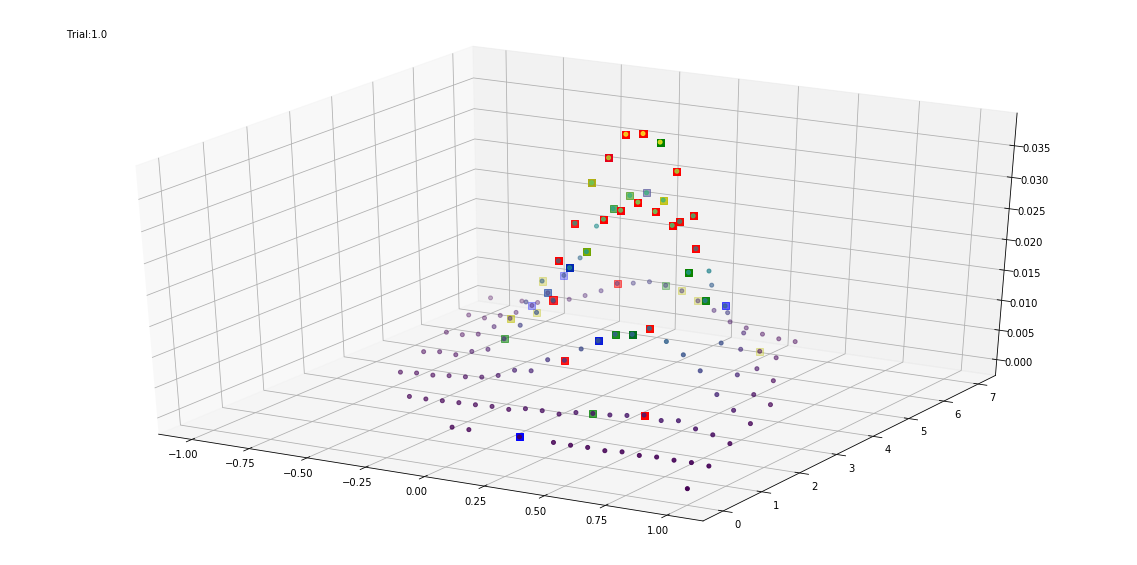

In [22]:
# Run the test code
anim = test_ktcr()

In [23]:
anim